<a href="https://colab.research.google.com/github/anna-alt/AI-Lab/blob/main/SceneRecognition7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler, ConcatDataset
from torchvision import datasets, transforms
from torchvision import models
import os
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device

device(type='cuda')

In [64]:
trainset_size = 5000
val_size = 100
num_epochs = 10
image_size = (224,224)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [45]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Resize(image_size),
                              
                              ])
# Download and load the training data
trainset = datasets.SUN397('/content/drive/MyDrive/Data', download= False, transform=transform)
splittrain = torch.utils.data.random_split(trainset, [trainset_size, len(trainset) - trainset_size])[0]
train_loader = DataLoader(splittrain, batch_size=32,num_workers = 2, shuffle=True)

validationset = datasets.SUN397("/content/drive/MyDrive/Data", download=False, transform=transform)
splitvalidation = torch.utils.data.random_split(validationset, [val_size, len(trainset) - val_size])[0]
val_loader = DataLoader(splitvalidation, batch_size=32,num_workers = 2, shuffle=True)



In [50]:
classes = list()


with open("/content/drive/MyDrive/Data/SUN397/ClassName.txt") as class_file:
      for line in class_file:
          line = line.split()[0]
          split_indices = [i for i, letter in enumerate(line) if letter == '/']
          # Check if there a class with a subclass inside (outdoor, indoor)
          if len(split_indices) > 2:
              line = line[:split_indices[2]] + '-' + line[split_indices[2]+1:]

          classes.append(line[split_indices[1] + 1:])
          
        # Get number of classes
print(len(classes))

print(classes)



397
['abbey', 'airplane_cabin', 'airport_terminal', 'alley', 'amphitheater', 'amusement_arcade', 'amusement_park', 'anechoic_chamber', 'apartment_building-outdoor', 'apse-indoor', 'aquarium', 'aqueduct', 'arch', 'archive', 'arrival_gate-outdoor', 'art_gallery', 'art_school', 'art_studio', 'assembly_line', 'athletic_field-outdoor', 'atrium-public', 'attic', 'auditorium', 'auto_factory', 'badlands', 'badminton_court-indoor', 'baggage_claim', 'bakery-shop', 'balcony-exterior', 'balcony-interior', 'ball_pit', 'ballroom', 'bamboo_forest', 'banquet_hall', 'bar', 'barn', 'barndoor', 'baseball_field', 'basement', 'basilica', 'basketball_court-outdoor', 'bathroom', 'batters_box', 'bayou', 'bazaar-indoor', 'bazaar-outdoor', 'beach', 'beauty_salon', 'bedroom', 'berth', 'biology_laboratory', 'bistro-indoor', 'boardwalk', 'boat_deck', 'boathouse', 'bookstore', 'booth-indoor', 'botanical_garden', 'bow_window-indoor', 'bow_window-outdoor', 'bowling_alley', 'boxing_ring', 'brewery-indoor', 'bridge', '

In [ ]:
model = models.resnet50(weights = "DEFAULT")
model.to(device)

In [63]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-8)
criterion = nn.CrossEntropyLoss()


In [61]:
def train(epoch, log_interval=20):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)
        
        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [ ]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    #ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    
    ax2.set_yticklabels(np.arange(10))

    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

tensor(0.4578) tensor(0.2640)


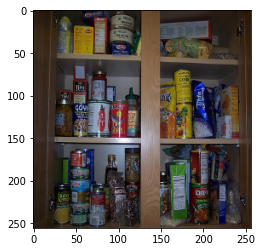

In [ ]:

z, _ = next(iter(val_loader))
print(z.mean(), z.std())
img_norm = z[0].permute(1, 2, 0).numpy()
plt.imshow(img_norm)

In [17]:
from sklearn import metrics
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
        #view_classify(data.cpu(), pred.cpu() )
    
        #print(plt.imshow(img_norm))
    val_loss /= len(val_loader)
    loss_vector.append(val_loss)

    

    accuracy = 100. * correct.to(torch.float32) / len(val_loader.dataset)
    accuracy_vector.append(accuracy)

        
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(val_loader.dataset), accuracy))


In [19]:
#Definisco una funzione per stampare la label predetta e quella corretta

def Predic(val_loader):
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        pred = torch.max(output, dim=1)[1] # get the index of the max log-probability
        print(metrics.confusion_matrix(target.cpu(), pred.cpu()))
        print(classes[pred[0].item()])
        print(classes[target[0].item()])


In [ ]:
Predic(val_loader)

church-outdoor
abbey


In [23]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [ ]:
lossv, accv = [], []
for epoch in range(1, num_epochs + 1):
    train(epoch)
    validate(lossv, accv)
    Predic(val_loader)

Train Epoch: 1 [0/10000 (0%)]	Loss: 2.251019
Train Epoch: 1 [640/10000 (6%)]	Loss: 2.224900
Train Epoch: 1 [1280/10000 (13%)]	Loss: 2.416425
Train Epoch: 1 [1920/10000 (19%)]	Loss: 1.667007
Train Epoch: 1 [2560/10000 (26%)]	Loss: 2.172078
Train Epoch: 1 [3200/10000 (32%)]	Loss: 1.910778
Train Epoch: 1 [3840/10000 (38%)]	Loss: 2.078457
Train Epoch: 1 [4480/10000 (45%)]	Loss: 2.703890
Train Epoch: 1 [5120/10000 (51%)]	Loss: 2.059549
Train Epoch: 1 [5760/10000 (58%)]	Loss: 1.911908
Train Epoch: 1 [6400/10000 (64%)]	Loss: 1.616411
Train Epoch: 1 [7040/10000 (70%)]	Loss: 1.818544
Train Epoch: 1 [7680/10000 (77%)]	Loss: 1.878797
Train Epoch: 1 [8320/10000 (83%)]	Loss: 1.818699
Train Epoch: 1 [8960/10000 (89%)]	Loss: 1.346965
Train Epoch: 1 [9600/10000 (96%)]	Loss: 2.158221

Validation set: Average loss: 1.9682, Accuracy: 538/1000 (54%)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]
lobby
ballroom
[[1 0 0 ... 0 0 0]
 [0

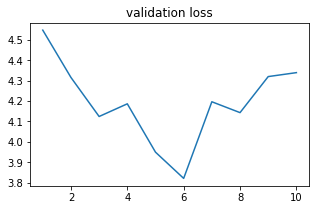

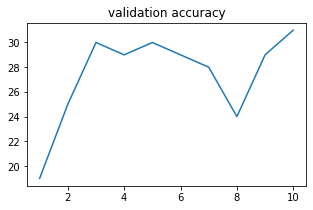

In [30]:

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,num_epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,num_epochs+1), accv)
plt.title('validation accuracy');
     

In [60]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = img.unsqueeze(0)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    preds  = torch.max(yb, dim=1)[1]
    # Retrieve the class label
    return classes[preds[0].item()]

from PIL import Image


def predict_external_image(img):
    image = img

    example_image = transform(image)
    plt.imshow(example_image.permute(1, 2, 0))
    print("The image resembles", predict_image(example_image,model.cpu()) + ".")

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

IndexError: ignored

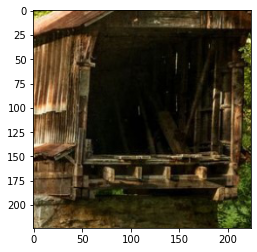

In [59]:
z = "/content/coveredbridge.jpg"
img = tf.keras.utils.load_img(
    z, target_size=(256, 256)
)

predict_external_image(img)